In [64]:
import pandas as pd
import datetime as dt
import quandl
import math
import numpy as np 
from sklearn import preprocessing, model_selection, svm #cross_validation is now model_selection
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt    
from matplotlib import style 
style.use('ggplot') 




In [66]:
#Setting up dataframe
df = quandl.get('WIKI/GOOGL')
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_pct'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.00
#Low minus high divided by open, for pct change
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.00

df = df[['Adj. Close', 'HL_pct', 'PCT_change', 'Adj. Volume']]
print(df.head())

Adj. Close    HL_pct  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  3.712563    0.324968   44659000.0
2004-08-20   54.322689  0.710922    7.227007   22834300.0
2004-08-23   54.869377  3.729433   -1.227880   18256100.0
2004-08-24   52.597363  6.417469   -5.726357   15247300.0
2004-08-25   53.164113  1.886792    1.183658    9188600.0


In [67]:
#Simple labelling

#col for forecasts
forecast_col = 'Adj. Close'
#fill missing data, to be treated as outlier
df.fillna(-99999, inplace=True)
#Will try and predict out 1% of df
forecast_out = int(math.ceil(0.01*len(df)))

#Shift columns negatively, will shift cols up the df.
#Label col for each row will be adj close price from the future 1% ahead. About 30 days with current dataset
df['label'] = df[forecast_col].shift(-forecast_out)
#df.dropna(inplace=True)
#print(df.head())


In [20]:
'''
#Pass to classifier
#Features with X, labels with y
X = np.array(df.drop(['label'], 1)) #convert  df as np array
y = np.array(df['label'])

X = preprocessing.scale(X)
df.dropna(inplace=True)
y = np.array(df['label'])
print(len(X), len(y))
'''


3019 3019


In [35]:
'''
#Training and testing set example
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2) #20% of data used for test

#choosing and fitting classifier
clf = LinearRegression(n_jobs=10) #Run 10 jobs at a time, use -1 uses as many jobs as possible by processor
clf.fit(X_train, y_train) #same as train
accuracy = clf.score(X_test, y_test) #for test score accuracy
print(accuracy)
'''

0.9626527866517232


In [34]:
'''
#Using support vector Regression example
#choosing and fitting classifier
#Kernels: default linear, try polynomial gives worse accuracy than default
clf = svm.SVR(kernel = 'poly')
clf.fit(X_train, y_train) 
accuracy = clf.score(X_test, y_test) 
print(accuracy)
'''

0.6664538995469755


In [ ]:
#From documentation, find algos that can be threaded
#param n_jobs  is number of jobs to use for computation, allows running in parallel operations
#Go to documentation and find n_jobs param for any algorithm
#Default for regression is 1

In [68]:
####
#X for features, y for label

X = np.array(df.drop(['label'], 1)) 
X = preprocessing.scale(X)
X_recent = X[-forecast_out:] #Do not have a y-val for these
X = X[:-forecast_out:]

df.dropna(inplace=True)
y = np.array(df['label'])
y = np.array(df['label'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

clf = LinearRegression(n_jobs=-1) #Run 10 jobs at a time, use -1 uses as many jobs as possible by processor
clf.fit(X_train, y_train) #same as train
accuracy = clf.score(X_test, y_test) #for test score accuracy
print(accuracy)


0.9770788767565197


[1100.96220348 1072.4261649  1020.73168377 1059.87042072 1072.09377004
 1072.26627198 1090.69513839 1109.85871197 1113.4758813  1121.55628129
 1131.19624738 1128.3348925  1147.17487724 1162.76452924 1135.4237756
 1121.58228705 1088.11370596 1101.82967266 1112.98842258 1119.83133656
 1133.57091644 1148.22527224 1179.58947655 1184.46562864 1157.43853214
 1167.35967129 1169.24813629 1152.38587237 1117.70338268 1113.78351337
 1111.85490502 1069.7471615  1042.64858616 1071.66130497 1022.25063695] 0.9770788767565197 35


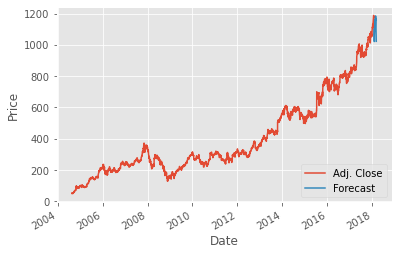

In [69]:
#Predictions
forecast_set = clf.predict(X_recent)
print(forecast_set, accuracy, forecast_out)

df['Forecast'] = np.nan

last_date = df.iloc[-1].name #Very last date
last_unix = last_date.timestamp()
one_day = 86400 #for unix time
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = dt.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    #takes all first cols, sets to nan for future data we don't have, sets final column to i
    df.loc[next_date] = [np.nan for x in range(len(df.columns)-1) ] + [i] #remember that df.loc references index

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()